# Sampling cost
The total cost for time evolution goes like $2 t  + \mathcal{O}(\log (1/\epsilon_{TE}))$, so to leading order in $t$ we need to multiply the qubitization costs by

$$
\mathrm{Cost} = \sum_i^{N_T} t_i = \Delta t N_t \times (N_t + 1) / 2
$$
assuming a regularly spaced grid of points, $\Delta t = t_\mathrm{max} / (N_t+1)$, so 
$$
\mathrm{Cost} = t_\mathrm{max} N_t / 2 
$$

We've seen before that if we allow $t_\mathrm{max}$ to vary, then the error in the slope, $\epsilon_S \sim \mathcal{O}(\sigma_{T}/t_\mathrm{max})$, for fixed $N_t$, and similarly, if we fix $t_{max}$ and vary $N_t$ we expect $\epsilon_S \sim \mathcal{O}(\sigma_{T}/N_{t}^{1/2})$, i.e., more similar to the reduction we might expect from just sampling. Thus we can obtain a cost complexity by writing $N_t = c_{N_t} \sigma_T^2/\epsilon_S^2$, and similarly for fixed $N_t$, $t_{\mathrm{max}} = c_{t_\mathrm{max}} \sigma_{T}/\epsilon_S$, where the costants are to be determined. Thus

$$
\mathrm{Cost} =  c_{N_t} \frac{t_{\mathrm{max}} \sigma_T^2}{2\epsilon_S^2}
$$
or
$$
\mathrm{Cost} = c_{t_\mathrm{max}} \frac{N_t \sigma_{T}}{2\epsilon_S}
$$

We are really in the first regime as the max time is determined by requiring the projectile travel some distance. This distance is fixed for all projectile velocities. 

In [188]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

# Look at some artificial data first
sigma = 4
v_proj = 2.0
mass_proj = 1836
max_distance = 170
tmax = max_distance / v_proj 
ke_0 = 0.5 * mass_proj * v_proj**2.0
stopping = 0.6
print(f"Tmax: {tmax}")

def linear(x, a, b):
    return a*x + b

def fit_linear(x, y, sigma=None, absolute_sigma=False):
    try:
        popt, pcov = scipy.optimize.curve_fit(linear, x, y, sigma=sigma, absolute_sigma=absolute_sigma)
        return popt, pcov
    except np.linalg.LinAlgError:
        return None

Tmax: 85.0


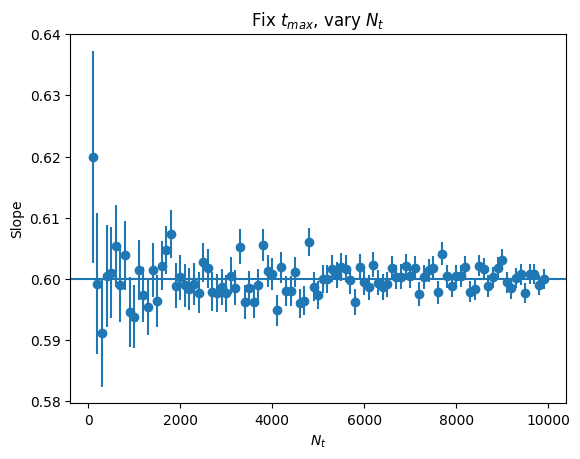

In [158]:

# Fix tmax vary, number of points Nt
res = []
cost = []
factor = []
num_pts = np.array(range(100, 10_000, 100))
for density in num_pts:
    xs = np.linspace(0, tmax, density)
    factor.append((tmax / density))
    cost.append(np.sum(xs))
    ys = linear(xs, stopping, ke_0) + np.random.normal(0.0, sigma, density)
    popt, pcov = fit_linear(xs, ys)
    res.append((popt[0], np.sqrt(pcov[0,0])))

slopes, err = zip(*res)
plt.errorbar(num_pts, slopes, yerr=err, fmt="o")
plt.xlabel("$N_t$")
plt.ylabel("Slope")
plt.title(r"Fix $t_{max}$, vary $N_t$")
plt.axhline(stopping)

In [155]:
xs, ys = np.log(num_pts), np.log(err)
trend, trend_err = fit_linear(xs, ys)
print(f"epsilon = N_t^({trend[0]:.2f})")
print(f"cNt = {np.exp(trend[0])/sigma**2.0}")

epsilon = N_t^(-0.50)
cNt = 0.03792214592626972


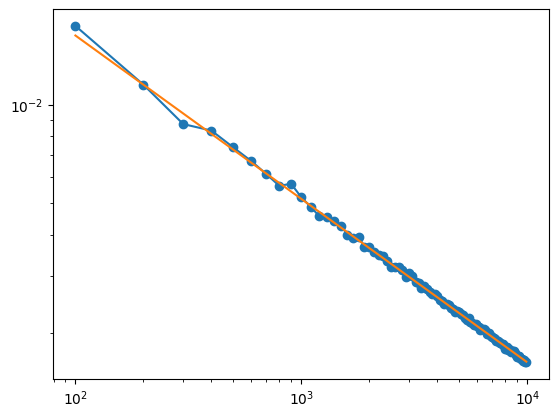

In [160]:
# Check the fit
plt.plot(num_pts, err, marker="o")
_x = num_pts 
plt.plot(_x, np.exp(trend[1])*_x**trend[0])
plt.yscale('log')
plt.xscale('log')

Text(0, 0.5, 'S')

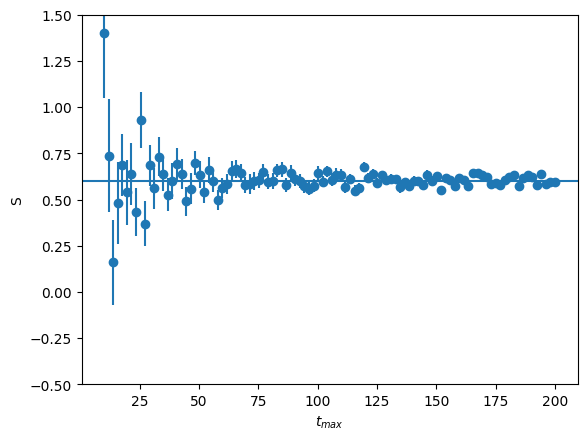

In [163]:
# Now vary tmax but fix N_t
res = []
cost = []
factor = []
num_pts = 100
sigma = 10.0
tmax = 200
tmaxs = np.linspace(10, tmax, 100)
for _tmax in tmaxs:
    xs = np.linspace(0, _tmax, num_pts+1)
    factor.append((tmax / density))
    cost.append(np.sum(xs))
    ys = linear(xs, stopping, ke_0) + np.random.normal(0.0, sigma, num_pts+1)
    popt, pcov = fit_linear(xs, ys)
    res.append((popt[0], np.sqrt(pcov[0,0])))

slopes, err = zip(*res)
plt.errorbar(tmaxs, slopes, yerr=err, fmt="o")
plt.axhline(stopping)
plt.ylim([-0.5, 1.5])
plt.xlabel("$t_{max}$")
plt.ylabel("S")

In [164]:
xs, ys = np.log(tmaxs), np.log(err)
trend, trend_err = fit_linear(xs, ys)
print(f"epsilon = N^({trend[0]:.2f})")
print(f"cNt = {np.exp(trend[0])/sigma}")

epsilon = N^(-1.01)
cNt = 0.03645166858281911


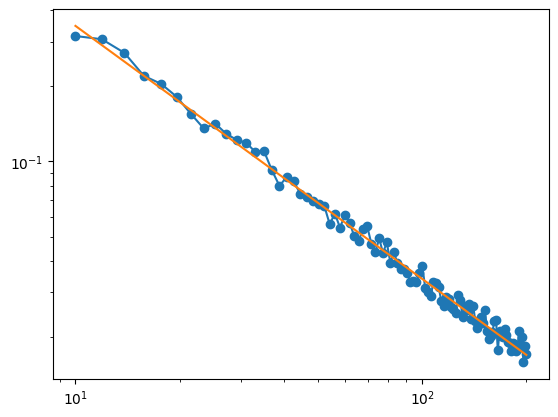

In [9]:
plt.yscale("log")
plt.xscale("log")
plt.plot(tmaxs, np.array(err), marker="o")
_x = tmaxs
plt.plot(_x, np.exp(trend[1])*_x**trend[0])

[-1.37589452  1.3780845 ]


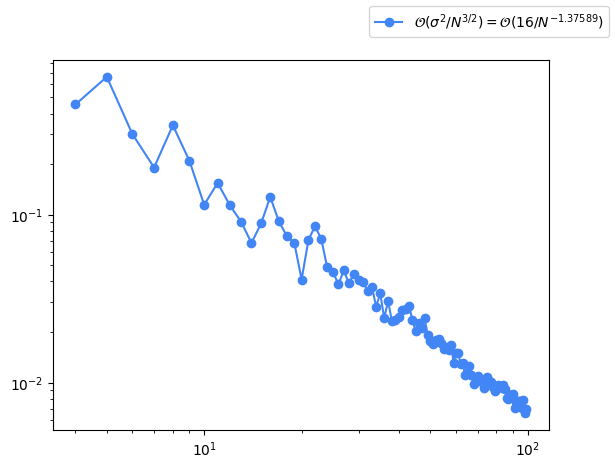

In [167]:
# From confirm_alina stopping sampling, find N^{-3/2}, both tmax and Nt vary here, hence 3/2 = 1 + 1/2 
s = stopping 
t = ke_0
n = 20
dx = 2
x1 = 3
sigmasquared = 10

x_i = lambda i: (x1 + (i - 1) * dx)
x = np.array([x_i(ii) for ii in range(1, n+1)])
y = s * x + t

fig, ax = plt.subplots(nrows=1, ncols=1)

num_trials = 50
colors = ['#4285F4', '#EA4335', '#FBBC04', '#34A853']

# for idx, sigmasquared in enumerate([5, 10, 15, 20]):
for idx, sigmasquared in enumerate([16]):
    average_slopes = []
    average_slopes_error = []
    n_vals = []
    for nn in range(4, 100):
        #nn = 2**n
        n_vals.append(int(nn))
        slopes = []
        intercepts = []
        for _ in range(num_trials):
            x_i = lambda i: (x1 + (i - 1) * dx)
            x = np.array([x_i(ii) for ii in range(0, int(nn)+1)])
            y = s * x + t
            y_noise = y + np.random.normal(0, scale=np.sqrt(sigmasquared), size=int(nn)+1)
        popt, pcov = fit_linear(x, y_noise)
        slopes.append(popt[0])
        intercepts.append(popt[1])

        average_slopes.append(slopes)
        average_slopes_error.append(np.sqrt(pcov[0,0]))

    #print(average_slopes_error)
    popt, pcov = fit_linear(np.log(n_vals), np.log(average_slopes_error))
    print(popt)
    slopescaling = np.around(popt[0], 5)
    ax.loglog(n_vals, average_slopes_error, 'o-', label=fr'$\mathcal{{O}}(\sigma^{2}/N^{{3/2}}) = \mathcal{{O}}({{{sigmasquared}}}/N^{{{slopescaling}}})$',
                color=colors[idx])

fig.legend()

# Actual stopping Data

* Cost vs error in stopping for different velocities
* Look at single velocity first

In [11]:
# Let's read in the Carbon example provided by Sandia
import numpy as np
from mec_sandia.vasp_utils import read_vasp
import matplotlib.pyplot as plt
import scipy.optimize

ase_cell = read_vasp(f"../vasp_data/C_POSCAR")
# Next we can get some system paramters
volume_ang = ase_cell.get_volume()
print("Volume = {} A^3".format(volume_ang))

# To compute rs parameter we need volume in Bohr
from ase.units import Bohr

volume_bohr = volume_ang / Bohr**3
# and the number of valence electrons
num_carbon = len(np.where(ase_cell.get_atomic_numbers() == 6)[0])
# There is 1 hydrogen atom in the cell
num_elec = 1 + num_carbon * 4
from mec_sandia.vasp_utils import compute_wigner_seitz_radius

# Get the Wigner-Seitz radius
rs = compute_wigner_seitz_radius(volume_bohr, num_elec)
print("rs = {} bohr".format(rs))
sim_res = []
act_res = []
qData2 = np.loadtxt("AndrewsFirstGaussian/C_10gpcc_1eV_stopping_config1.txt")
velocity_au = qData2[:, 0]  # the velocities are already given in atomic units

from mec_sandia.stopping_power import (
    parse_stopping_data,
    compute_stopping_power,
    _fit_linear,
)
from ase.units import Bohr, Hartree

stopping_err = 0.1  # eV/A
stopping_err_au = stopping_err * Bohr / Hartree
sigma_k = 1
# Get DFT data
qData1 = np.loadtxt("AndrewsFirstGaussian/4.0_work_vs_dist")
position_au = qData1[:, 0] / (
    0.529
)  # divide the positions (angstroms) by the number of angstroms per atomic unit
time_au = (
    position_au / 4.0
)  # divide the positions in atomic units by the velocity in atomic units to get the time in atomic units
work_au = (
    qData1[:, 1] / 27.2
)  # divide the work in eV by the number of eV per atomic unit of energy

# load the full stopping curve
qData2 = np.loadtxt("AndrewsFirstGaussian/C_10gpcc_1eV_stopping_config1.txt")
velocity_au = qData2[:, 0]  # the velocities are already given in atomic units
stopping_au = qData2[:, 1] * (
    0.529 / 27.2
)  # the stopping powers are given in eV/A, so we multiply by the number of A/bohr and divide by the number of eV/Ha
# plt.plot(velocity_au, stopping_au, marker="o", lw=0)
from scipy.interpolate import CubicSpline

stopping_spl = CubicSpline(velocity_au, stopping_au)
xs = np.linspace(velocity_au[0], velocity_au[-1], 100)
stopping_deriv_spl = stopping_spl.derivative(1)

mass_proj = 1838
ecut_ha = 10000 / Hartree
sigma_k = 4
box_length = volume_bohr ** (1.0 / 3.0)
print("box_length = {} bohr".format(box_length))
vel = 2.0


Volume = 255.27133939199965 A^3
rs = 0.9289611708818379 bohr
box_length = 11.987617756468008 bohr


* Look at cost decrease as max_time is reduced (i.e. the distance is reduce) for a fixed number of points.

In [12]:
vel = 2.0
dft_data = parse_stopping_data(
    f"AndrewsFirstGaussian/{vel}_work_vs_dist",
    vel,
    mass_proj=mass_proj,
    num_points=20,
    rare_event=0.25,
    random_sub_sample=False,
)
max_time = dft_data.times[-1]
print(dft_data.distance[-1])
print(dft_data.distance_sub_sample[-1])
print(f"cost = {sum(dft_data.time_sub_sample)}")


151.6254785420197
148.70466877853335
cost = 898.2519984843008


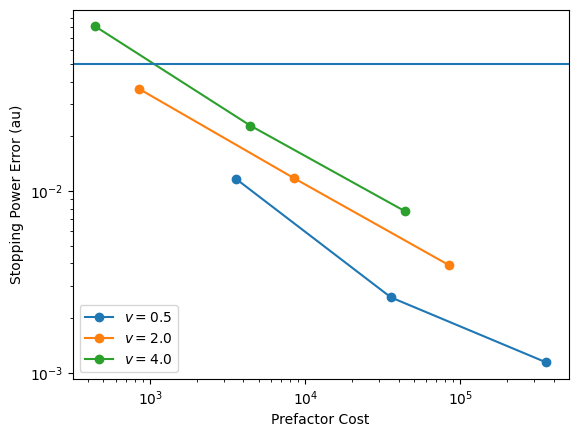

In [13]:
for vel in [0.5, 2.0, 4.0]:
    dft_data = parse_stopping_data(
        f"AndrewsFirstGaussian/{vel}_work_vs_dist",
        vel,
        mass_proj=mass_proj,
        num_points=100,
        rare_event=0.25,
        random_sub_sample=False,
    )
    max_time = dft_data.times[-1]
    max_times = np.linspace(10, max_time, 10)
    errs = []
    costs = []
    for ns in [1, 10, 100]:
        # for max_t in max_times: 
        dft_data = parse_stopping_data(
            f"AndrewsFirstGaussian/{vel}_work_vs_dist",
            vel,
            mass_proj=mass_proj,
            num_points=20,
            rare_event=0.5,
            random_sub_sample=False,
            max_time=max_times[-1],
        )
        kproj_vals = np.array(
            [np.array([kx, 0, 0]) for kx in dft_data.kproj_sub_sample]
        )
        stopping_data = compute_stopping_power(
            ecut_ha,
            box_length,
            sigma_k,
            dft_data.time_sub_sample,
            kproj_vals,
            stopping_deriv_spl(vel),
            mass_proj,
            num_samples=ns,
        )
        costs.append(ns*np.sum(dft_data.time_sub_sample))
        #costs.append(dft_data.distance_sub_sample[-1])
        errs.append(stopping_data.stopping_err)
    plt.plot(costs, errs, marker="o", label=fr"$v = ${vel}")
stopping_err_au = 0.05 #0.2 * Bohr / Hartree
plt.xlabel("Prefactor Cost")
plt.axhline(stopping_err_au)
plt.ylabel(r"Stopping Power Error (au)")
plt.legend()
plt.yscale("log")
plt.xscale("log")

# Check

1. Precision in individual points vs precision in stopping power

Setup: Fix calculation to use 20 points and sample, check individual point goes like $N^{-1/2}$.

T max: 76.87603779349224
sigma_k: 4


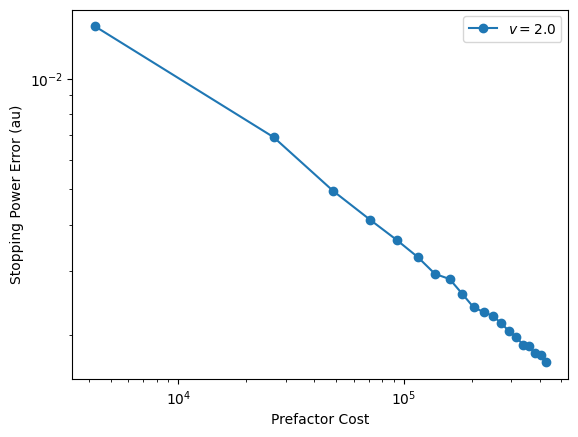

In [14]:
vel = 2.0
# 1. Get stopping power data from file
dft_data = parse_stopping_data(
    f"AndrewsFirstGaussian/{vel}_work_vs_dist",
    vel,
    mass_proj=mass_proj,
    num_points=20,
    rare_event=0.25,
    random_sub_sample=False,
)
max_time = dft_data.times[-1]
max_times = np.linspace(10, max_time, 10)
print(f"T max: {max_time}")
print(f"sigma_k: {sigma_k}")
errs = []
costs = []
ke_errs = []
# ns is the number of samples we use to estimate the kinetic energy at each
# point along the work / distance line.
data = {}
samples = np.linspace(10, 1000, 20, dtype=int)
for ns in samples:
    dft_data = parse_stopping_data(
        f"AndrewsFirstGaussian/{vel}_work_vs_dist",
        vel,
        mass_proj=mass_proj,
        num_points=10,
        rare_event=0.25,
        random_sub_sample=False,
        max_time=max_times[-1],
    )
    kproj_vals = np.array(
        [np.array([kx, 0, 0]) for kx in dft_data.kproj_sub_sample]
    )
    stopping_data = compute_stopping_power(
        ecut_ha,
        box_length,
        sigma_k,
        dft_data.time_sub_sample,
        kproj_vals,
        stopping_deriv_spl(vel),
        mass_proj,
        num_samples=ns,
    )
    data[ns] = stopping_data
    costs.append(ns*np.sum(dft_data.time_sub_sample))
    errs.append(stopping_data.stopping_err)
    ke_errs.append(np.mean(stopping_data.kinetic_err))
plt.plot(costs, errs, marker="o", label=fr"$v = ${vel}")
plt.xlabel("Prefactor Cost")
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r"Stopping Power Error (au)")
plt.legend()

60.63002556489647
[12.26476149  4.92564675  3.63250885  3.01026731  2.6268233   2.36035445
  2.16138021  2.00550295  1.8791191   1.77396546  1.68310747  1.60629323
  1.53911916  1.47972407  1.42671388  1.37902095  1.33581194  1.29642557
  1.26032955  1.22647615]


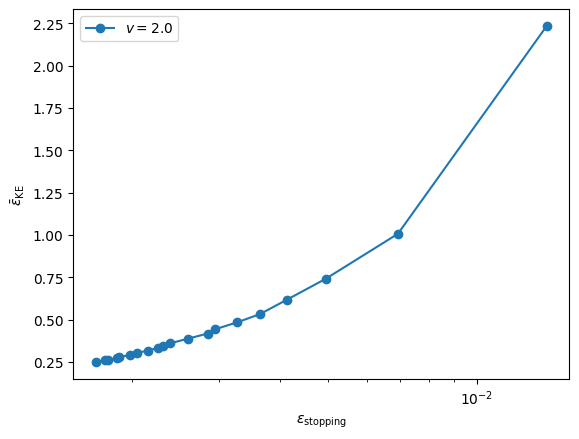

In [15]:
kproj = mass_proj * vel
mean = kproj**2.0
print(np.sqrt(mean/(2*mass_proj)))
var_ke = (4 * mean * sigma_k**2 ) / (2*mass_proj)
var_ke = 6 * sigma_k**4 / (2*mass_proj)
print(60 * np.sqrt(var_ke)/np.sqrt(samples))
plt.plot(errs, ke_errs, marker="o", label=fr"$v = ${vel}")
#plt.plot(errs, np.sqrt(var_ke) / np.sqrt(samples), marker="o", label=fr"$v = ${vel}")
plt.xlabel(r"$\varepsilon_{\mathrm{stopping}}$")
plt.ylabel(r"$\bar{\varepsilon}_{\mathrm{KE}}$")
plt.xscale("log")
#plt.yscale("log")
plt.legend()


In [17]:
from mec_sandia.gaussians import estimate_kinetic_energy_sampling
sigma_k = 4
func = lambda ns: estimate_kinetic_energy_sampling(
    ecut_ha, box_length, sigma_k, ndim=3, num_samples=ns, kproj=np.array([kproj, 0, 0])
)
xs = range(10, 10000, 50)
errs = [func(ns)[1] for ns in xs]

$Var[k^2] = 4 k^2 \sigma_k^2 + 6 \sigma_k^4$, so $\sigma_T^2 = \sqrt{Var[k^2]}/(2 m_p) $, and $k = m_p v$ so $\sigma_T = v \sigma_k + \sqrt{6} \sigma_k^2 / (2 m_p) \approx v \sigma_k = 2 \times 4  = 8$

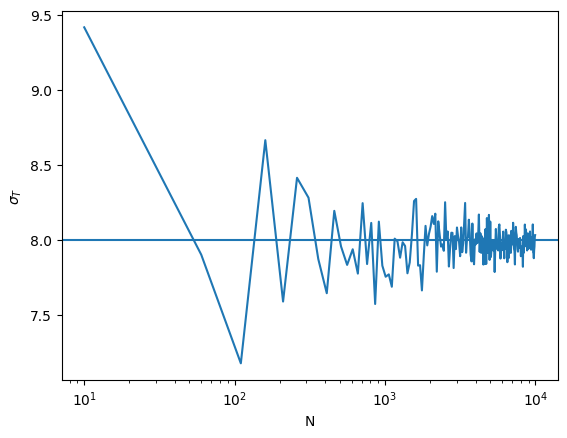

In [18]:
from mec_sandia.gaussians import kinetic_variance_exact
plt.plot(xs, errs * np.sqrt(xs) / (mass_proj))
var = kinetic_variance_exact(kproj**2, sigma_k)
plt.axhline(var**0.5 / (2*mass_proj))
plt.xlabel("N")
plt.ylabel("$\sigma_T$")
plt.xscale("log")

10 [3.0, 12.0, 64.0, 356.0, 2001.0]
10 [5.0, 23.0, 127.0, 712.0, 4001.0]
10 [9.0, 45.0, 253.0, 1423.0, 8001.0]
10 [17.0, 90.0, 506.0, 2846.0, 16001.0]
10 [21.0, 113.0, 633.0, 3557.0, 20001.0]


Text(0, 0.5, '$\\epsilon_T$')

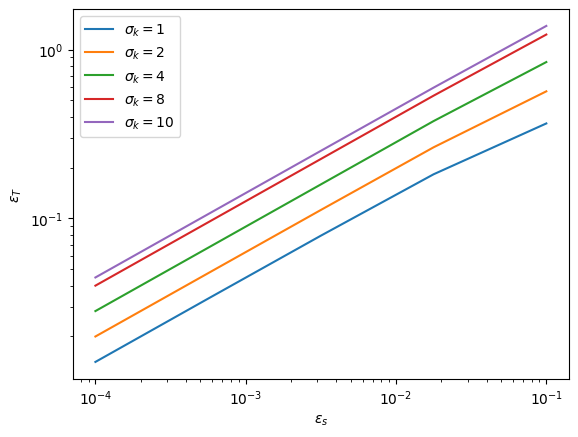

In [19]:
for sk in [1, 2, 4, 8, 10]:
    ns = 10
    nt = np.linspace(1, 100, 5)
    eps_s = np.logspace(-1, -4, 10)
    var = kinetic_variance_exact(kproj**2, sk)
    sigma_t = var**0.5 / (2*mass_proj)
    eps_s = np.logspace(-1, -4, 5)
    nts = [np.ceil(sigma_t / (ns * es)) for es in eps_s]
    print(ns, nts)
    plt.plot(eps_s, sigma_t / np.sqrt(ns * np.array(nts)), label=f'$\sigma_k = {sk}$')
    plt.xscale('log')
    plt.yscale('log')
plt.legend()
plt.xlabel('$\epsilon_s$')
plt.ylabel('$\epsilon_T$')

In [21]:
print(ke_errs)
xs, ys = np.log(samples), np.log(errs)
trend, trend_err = fit_linear(xs, ys)
print(f"epsilon = N^({trend[0]:.2f})")
print(f"cNt = {np.exp(trend[0])/sigma**2.0}")

[2.3133949669328975, 2.4421013687121818, 2.4329284580265056, 2.437270727144973, 2.4580103220020293, 2.3958395525772436, 2.420723205967315, 2.4511948815712015, 2.3995027024678803, 2.42623162485148, 2.475981128890911, 2.3818115089921883, 2.411542131618213, 2.4753352923526992, 2.4488927415408557, 2.431989151193187, 2.4387183795749494, 2.4819813157526283, 2.454173982661251, 2.4450724179436953]
epsilon = N^(-0.45)
cNt = 0.006357287115482457


In [168]:
# Artificial stopping data
gen_s = lambda x: stopping_data.stopping * x + stopping_data.intercept

0.6530036986050328
0.016072566036924828


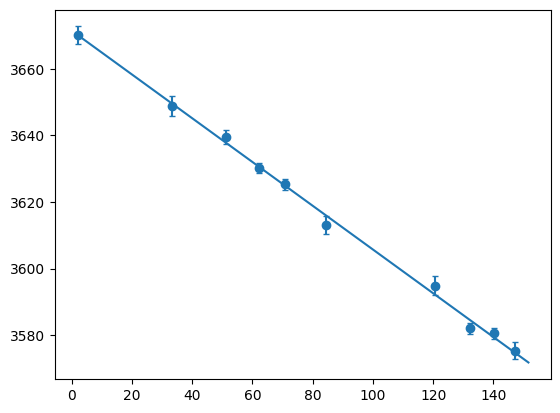

In [172]:
xs = dft_data.distance
plt.plot(xs, gen_s(xs))
np.random.seed(7)
vel = 2.0
dft_data = parse_stopping_data(
    f"AndrewsFirstGaussian/{vel}_work_vs_dist",
    vel,
    mass_proj=mass_proj,
    num_points=10,
    rare_event=0.25,
    random_sub_sample=False,
    max_time=max_times[-1],
    stopping_data_filename="AndrewsFirstGaussian/C_10gpcc_1eV_stopping_config1.txt"
)
print(dft_data.stopping)
kproj_vals = np.array(
    [np.array([kx, 0, 0]) for kx in dft_data.kproj_sub_sample]
)
sigma_k = 4
stopping_data = compute_stopping_power(
    ecut_ha,
    box_length,
    sigma_k,
    dft_data.time_sub_sample,
    kproj_vals,
    stopping_deriv_spl(vel),
    mass_proj,
    num_samples=10,
)
plt.errorbar(stopping_data.distance, stopping_data.kinetic, stopping_data.kinetic_err, fmt='o', capsize=2, color="C0")
import scipy.optimize
from mec_sandia.stopping_power import _fit_linear
popt, pcov = scipy.optimize.curve_fit(
    _fit_linear,
    stopping_data.distance,
    stopping_data.kinetic,
    sigma=stopping_data.kinetic_err,
    absolute_sigma=True,
)
# print(stopping_data.stopping_expected)
# print(popt, np.sqrt(pcov[0,0]))
from mec_sandia.stopping_power import bootstrap
slope, err = bootstrap(stopping_data.distance, stopping_data.kinetic, stopping_data.kinetic_err, nsamp=10_000) 
print(err)
# print(slope-popt[0], err)
# print(10 * stopping_data.kinetic_err**2)

<ErrorbarContainer object of 3 artists>

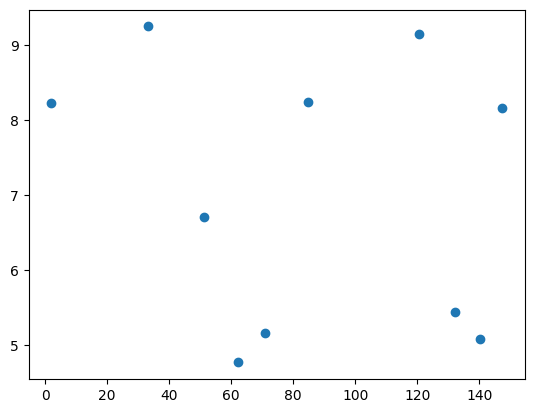

In [171]:
# Check the variance is around 8
plt.errorbar(stopping_data.distance, stopping_data.num_samples**0.5 * stopping_data.kinetic_err, fmt='o', capsize=2, color="C0")

In [137]:
sigma_k = 4
var = kinetic_variance_exact(kproj**2, sigma_k)
sigma_ke = np.sqrt(var) / (2*mass_proj)

8.000007104279426


10
20
40
47
58
76
94


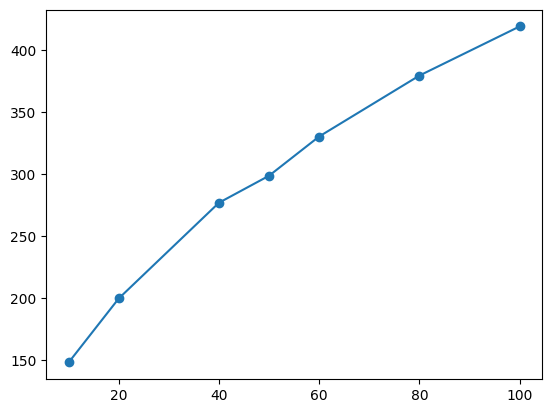

In [150]:
nps = [10, 20, 40, 50, 60, 80, 100]
ratio = []
for npoints in nps:
    dft_data = parse_stopping_data(
        f"AndrewsFirstGaussian/{vel}_work_vs_dist",
        vel,
        mass_proj=mass_proj,
        num_points=npoints,
        rare_event=0.25,
        random_sub_sample=False,
        max_time=max_times[-1],
        stopping_data_filename="AndrewsFirstGaussian/C_10gpcc_1eV_stopping_config1.txt"
    )
    print(len(dft_data.time_sub_sample))
    kproj_vals = np.array(
        [np.array([kx, 0, 0]) for kx in dft_data.kproj_sub_sample]
    )
    stopping_data = compute_stopping_power(
        ecut_ha,
        box_length,
        sigma_k,
        dft_data.time_sub_sample,
        kproj_vals,
        stopping_deriv_spl(vel),
        mass_proj,
        num_samples=10,
    )
    xs = stopping_data.distance 
    slopes = []
    nss = range(10, 10_000, 10)
    for ns in nss:
        ys_err = gen_s(xs)[None, :] + np.random.normal(0, scale=sigma_ke, size=ns*len(xs)).reshape(ns, len(xs))
        popt, pcov = scipy.optimize.curve_fit(
            _fit_linear,
            xs,
            np.mean(ys_err, axis=0),
            sigma=np.std(ys_err, ddof=1, axis=0) / len(ys_err)**0.5,
            absolute_sigma=True,
        )
        slopes.append((abs(popt[0]), pcov[0,0]**0.5))
    s, se = zip(*slopes)
    x_err = sigma_ke / np.sqrt(np.array(nss))
    popt, pcov = scipy.optimize.curve_fit(
        _fit_linear,
        x_err,
        se,
    )
    ratio.append((np.mean(x_err/se)))


plt.plot(nps, ratio, marker='o')

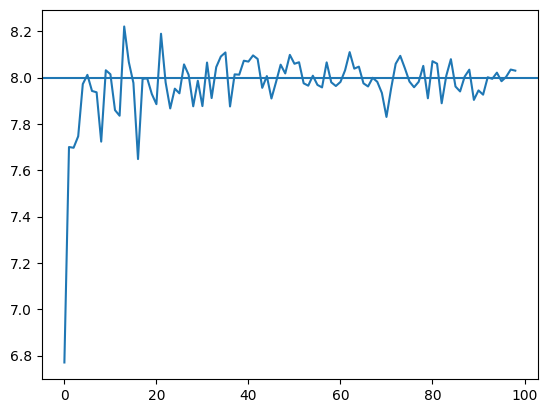

In [101]:
# check variance is ~ 8
stds = []
for ns in range(10, 1000, 10):
    ys_err = gen_s(xs)[None, :] + np.random.normal(0, scale=sigma_ke, size=ns*len(xs)).reshape(ns, len(xs))
    stds.append(np.mean(np.std(ys_err, axis=0)))
plt.plot(stds)
plt.axhline(sigma_ke)

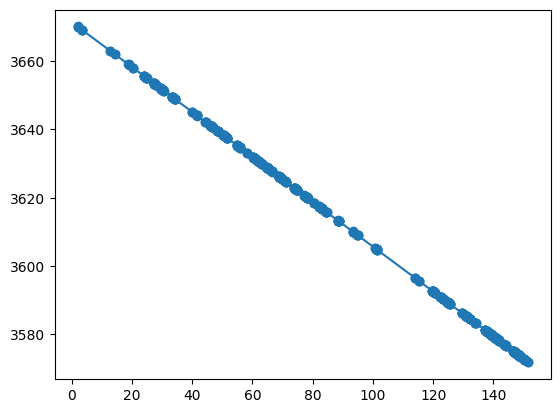

In [175]:
# Plot precision in slope vs precision in T for fixed t_max
# stds = []
# print(xs)
# for ns in range(1, 1000, 10):
#     ys_err = gen_s(xs)[None, :] + np.random.normal(0, scale=sigma_ke, size=ns*len(xs)).reshape(ns, len(xs))
# slope, err = bootstrap(stopping_data.distance, stopping_data.kinetic, stopping_data.kinetic_err, nsamp=10_000) 

vel = 0.5, ke = 228.68622118180798, sigma_ke = 1.9964795033974665
vel = 1.5, ke = 2064.0583513291845, sigma_ke = 5.9979152329856245
vel = 2.5, ke = 5735.56685384145, sigma_ke = 9.99832089588377
vel = 3.5, ke = 11243.801012865972, sigma_ke = 13.998946458219912
vel = 4.5, ke = 18587.83181082327, sigma_ke = 17.9991955021239


Text(0, 0.5, '$\\epsilon_S$')

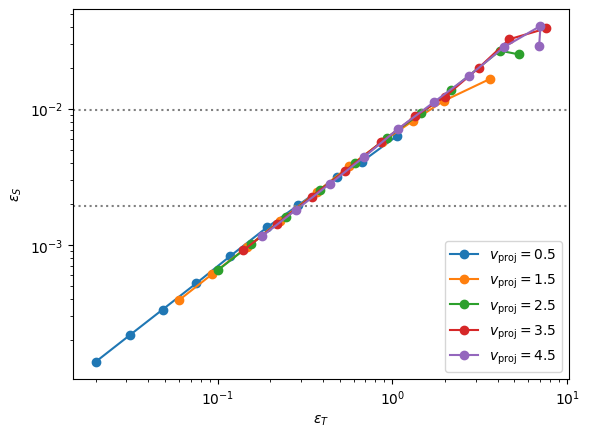

In [256]:
plt.cla()
stopping_err = 0.1  # eV/A
stopping_err_au = stopping_err * Bohr / Hartree
sigma_k = 4
mass_proj = 1836
for vel in velocity_au[::2]:
    dft_data = parse_stopping_data(
        f"AndrewsFirstGaussian/{vel}_work_vs_dist",
        vel,
        mass_proj=mass_proj,
        num_points=10,
        rare_event=0.25,
        random_sub_sample=False,
    )
    kproj = dft_data.kproj[0]
    var = kinetic_variance_exact(kproj**2, sigma_k)
    sigma_ke = np.sqrt(var) / (2*mass_proj)
    ke = kproj ** 2 / (2*mass_proj)
    gen_s = lambda x: dft_data.stopping * x + ke
    print(f"vel = {vel}, ke = {ke}, sigma_ke = {sigma_ke}")
    xmax = dft_data.distance[-1]
    eps_t = []
    eps_s = []
    samples = [int(x) for x in np.logspace(0.5, 4, 10)]
    for ns in samples:
        xs = np.linspace(0, xmax, 10)
        # Generate 10 points with some noise and average to get sigma_T
        ys = gen_s(xs)[:, None] + np.random.normal(0.0, sigma_ke, 10*ns).reshape((10, ns))
        ys_mean = np.mean(ys, axis=1)
        ys_err = np.std(ys, axis=1, ddof=1) / np.sqrt(ns)
        # if ns == 35:
        #     plt.errorbar(xs, ys_mean, yerr=ys_err, fmt='o')
        popt, pcov = fit_linear(xs, ys_mean, ys_err, absolute_sigma=True)
        eps_t.append(np.mean(ys_err))
        eps_s.append(pcov[0,0]**0.5)
    plt.plot(eps_t, eps_s, marker='o', label=rf'$v_\mathrm{{proj}}={vel}$')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.axhline(stopping_err_au, color='grey', ls=':')
plt.axhline(5*stopping_err_au, color='grey', ls=':')
# plt.axvline(0.2, color='grey', ls=':')
# plt.axvline(0.8, color='grey', ls=':')
plt.xlabel('$\epsilon_T$')
plt.ylabel('$\epsilon_S$')

vel = 0.5, ke = 228.68622118180798, sigma_ke = 1.9964795033974665
vel = 1.5, ke = 2064.0583513291845, sigma_ke = 5.9979152329856245
vel = 2.5, ke = 5735.56685384145, sigma_ke = 9.99832089588377
vel = 3.5, ke = 11243.801012865972, sigma_ke = 13.998946458219912
vel = 4.5, ke = 18587.83181082327, sigma_ke = 17.9991955021239


Text(0, 0.5, '$\\epsilon_T$')

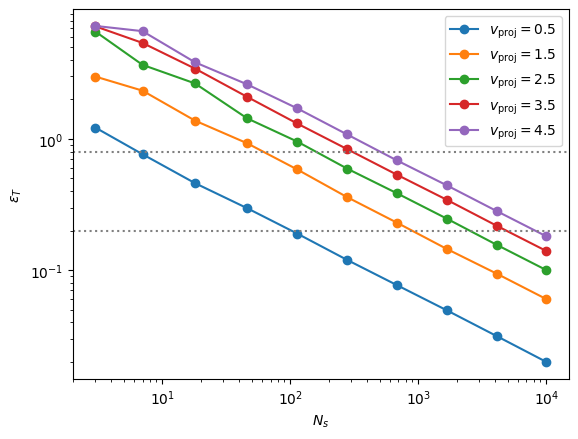

In [257]:
plt.cla()
stopping_err = 0.1  # eV/A
stopping_err_au = stopping_err * Bohr / Hartree
sigma_k = 4
mass_proj = 1836
for vel in velocity_au[::2]:
    dft_data = parse_stopping_data(
        f"AndrewsFirstGaussian/{vel}_work_vs_dist",
        vel,
        mass_proj=mass_proj,
        num_points=10,
        rare_event=0.25,
        random_sub_sample=False,
    )
    kproj = dft_data.kproj[0]
    var = kinetic_variance_exact(kproj**2, sigma_k)
    sigma_ke = np.sqrt(var) / (2*mass_proj)
    ke = kproj ** 2 / (2*mass_proj)
    gen_s = lambda x: dft_data.stopping * x + ke
    print(f"vel = {vel}, ke = {ke}, sigma_ke = {sigma_ke}")
    xmax = dft_data.distance[-1]
    eps_t = []
    eps_s = []
    samples = [int(x) for x in np.logspace(0.5, 4, 10)]
    for ns in samples:
        xs = np.linspace(0, xmax, 10)
        # Generate 10 points with some noise and average to get sigma_T
        ys = gen_s(xs)[:, None] + np.random.normal(0.0, sigma_ke, 10*ns).reshape((10, ns))
        ys_mean = np.mean(ys, axis=1)
        ys_err = np.std(ys, axis=1, ddof=1) / np.sqrt(ns)
        # if ns == 35:
        #     plt.errorbar(xs, ys_mean, yerr=ys_err, fmt='o')
        popt, pcov = fit_linear(xs, ys_mean, ys_err, absolute_sigma=True)
        eps_t.append(np.mean(ys_err))
        eps_s.append(pcov[0,0]**0.5)
    plt.plot(samples, eps_t, marker='o', label=rf'$v_\mathrm{{proj}}={vel}$')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.axhline(0.2, color='grey', ls=':')
plt.axhline(0.8, color='grey', ls=':')
plt.xlabel('$N_s$')
plt.ylabel('$\epsilon_T$')